In [ ]:
# Checking life expectancy for countries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [96]:
df = pd.read_csv('refined_life_expect.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


In [97]:
# remove 1% from the tail ends of our the data for life expectancy
IQR = [df.life_expectancy.quantile(0.99), df.life_expectancy.quantile(0.01)]
df = df[df.life_expectancy < IQR[0]] 
df = df[df.life_expectancy > IQR[1]] 
print(df.shape)

(1605, 19)


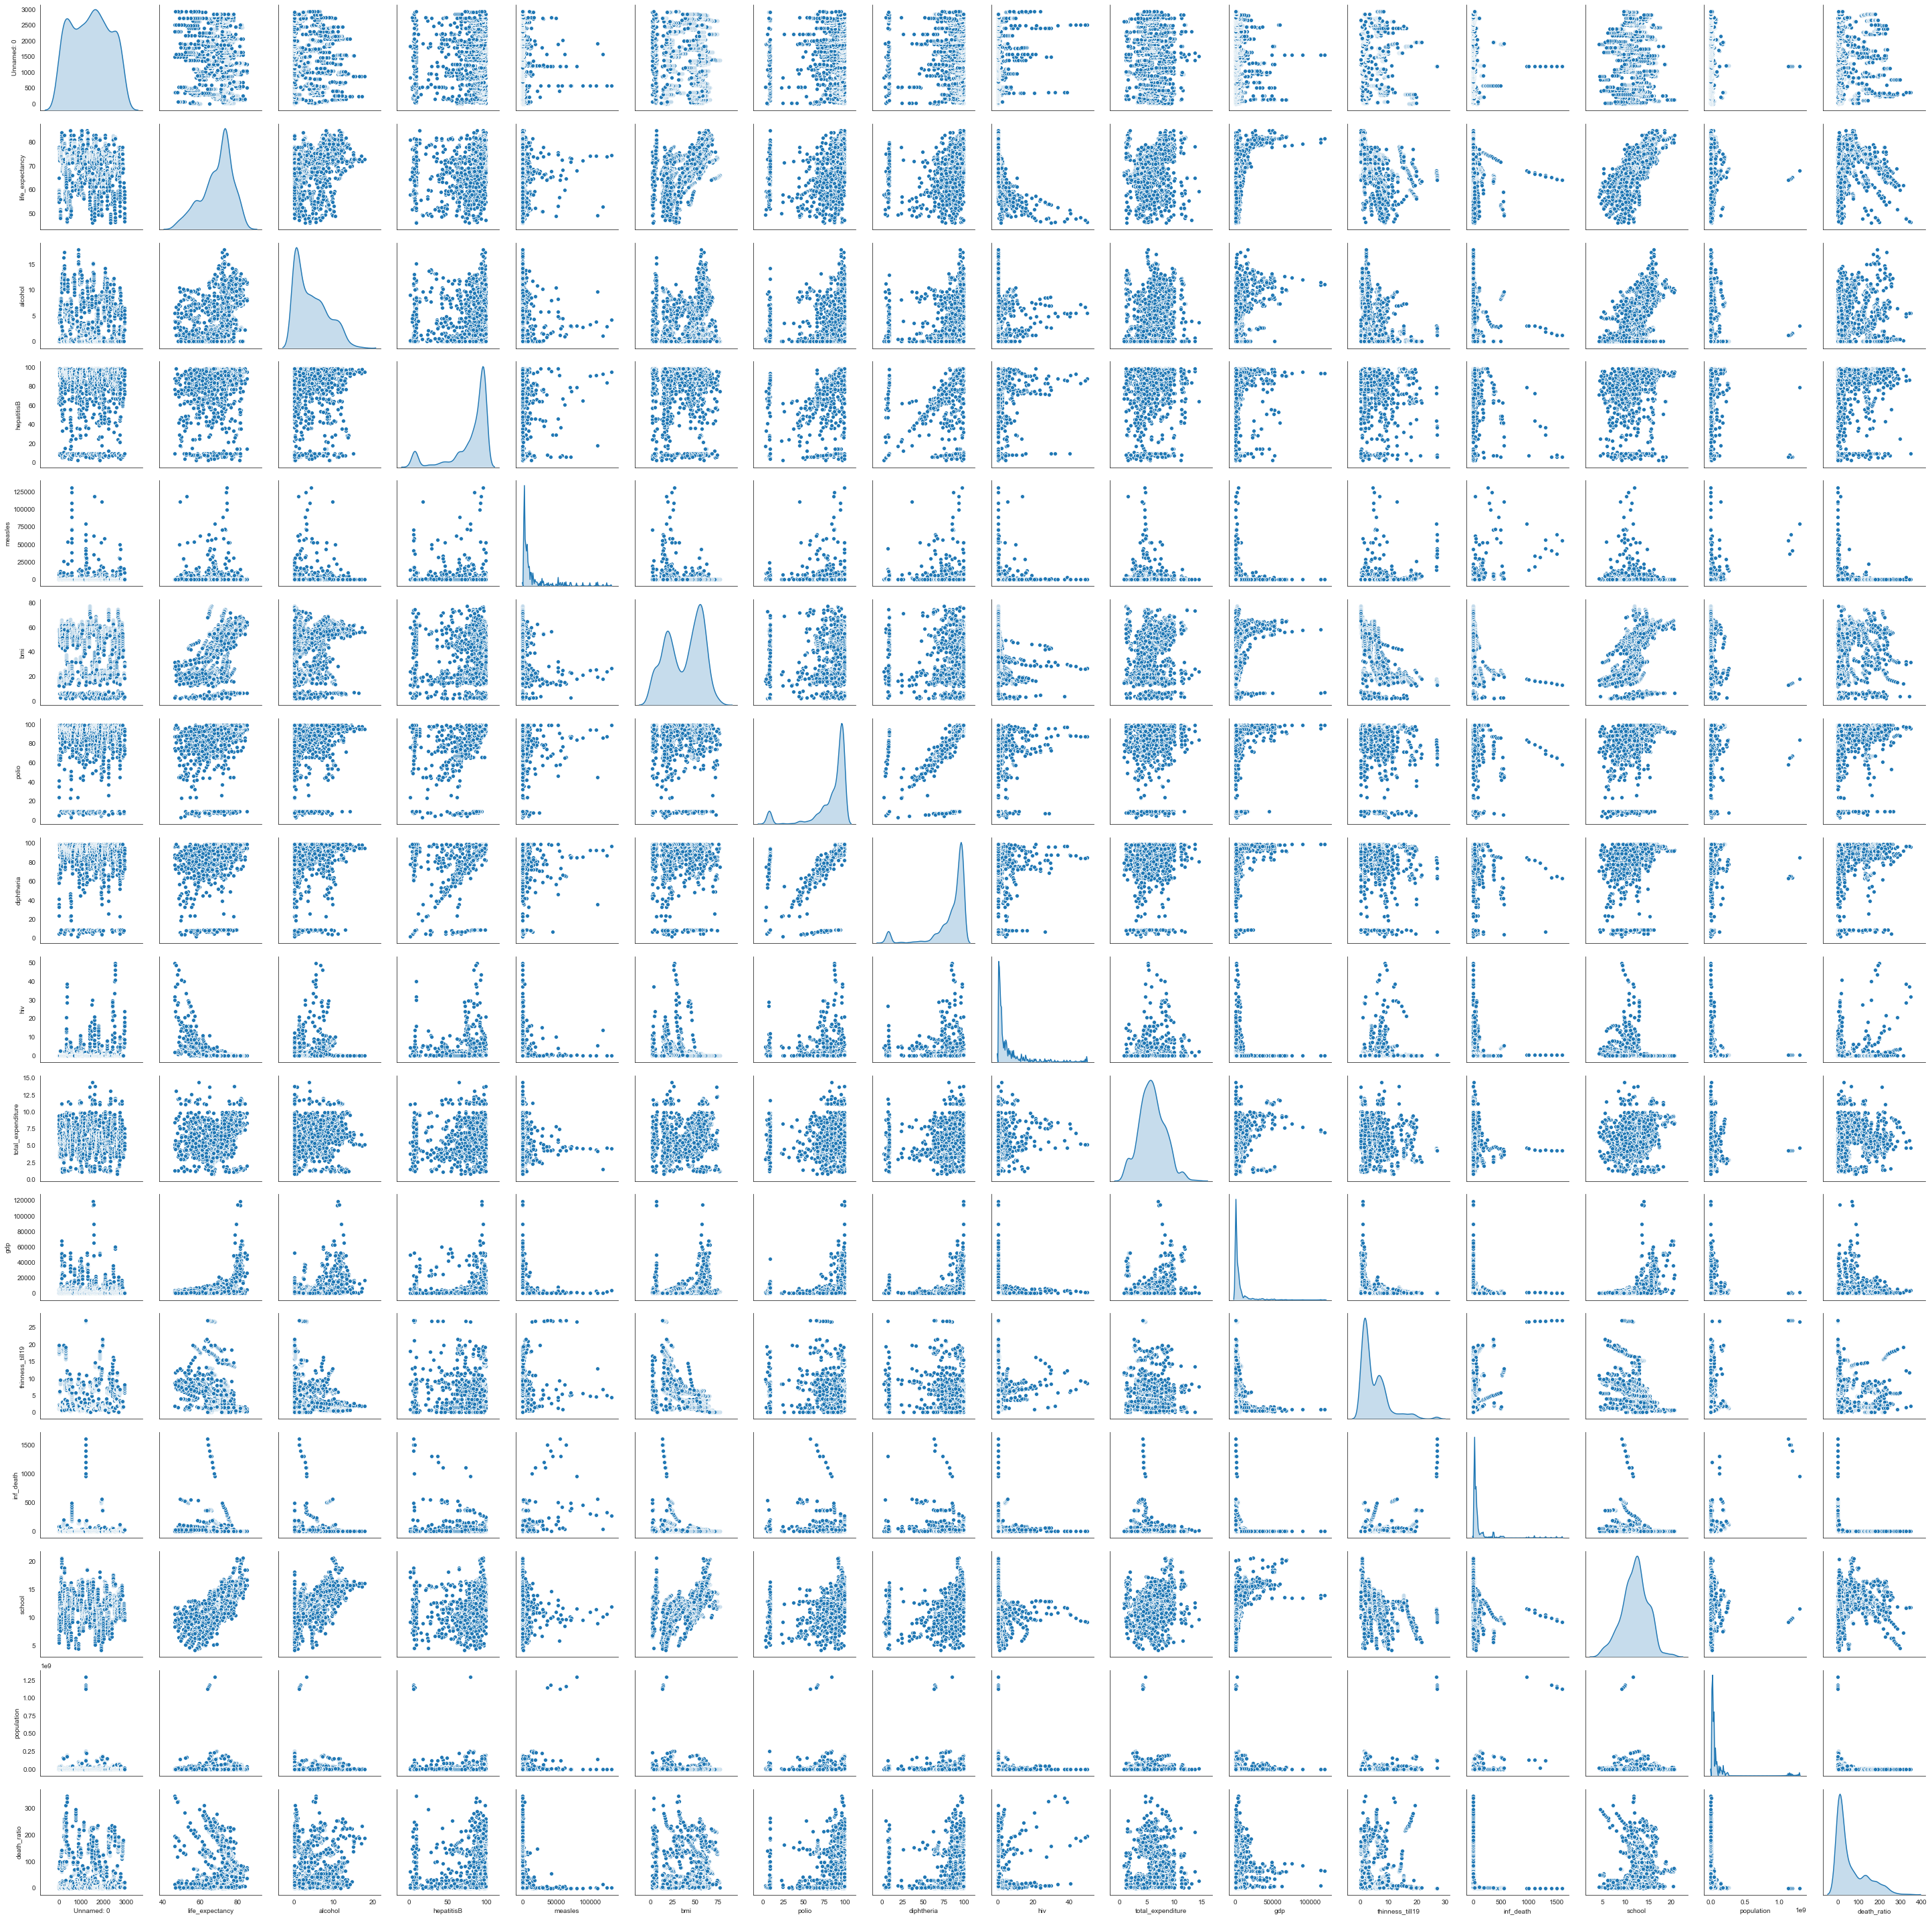

In [99]:
# check for outliers and look distribution of the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)

In [34]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# how thin, and schooling may have effect life expectancy
new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio']
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
corr_map

,life_expectancy,alcohol,bmi,hiv,gdp,thinness_till19,inf_death
life_expectancy,1.000000,0.341170,0.529667,-0.578422,0.436997,-0.452349,-0.310559
alcohol,0.341170,1.000000,0.291969,-0.004732,0.261025,-0.412529,-0.107906
bmi,0.529667,0.291969,1.000000,-0.245577,0.282664,-0.514594,-0.296392
hiv,-0.578422,-0.004732,-0.245577,1.000000,-0.125757,0.198607,0.135900
gdp,0.436997,0.261025,0.282664,-0.125757,1.000000,-0.234053,-0.145420
thinness_till19,-0.452349,-0.412529,-0.514594,0.198607,-0.234053,1.000000,0.264139
inf_death,-0.310559,-0.107906,-0.296392,0.135900,-0.145420,0.264139,1.000000


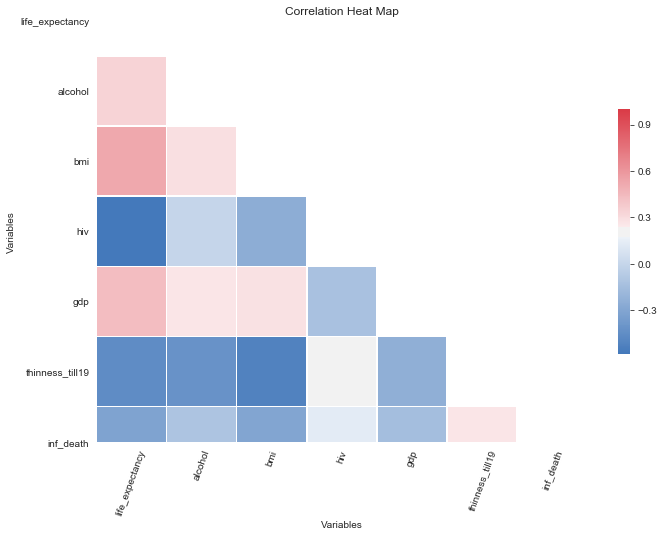

In [54]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # add titles
    plt.title("Correlation Heat Map")
   
    

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xlabel("Variables")
        plt.ylabel("Variables")
        plt.xticks(rotation=70)
        plt.yticks(rotation=0)
        
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xlabel("Variables")
        plt.ylabel("Variables")
        plt.xticks(rotation=70)
        plt.yticks(rotation=0)



CorrMtx(corr_map)

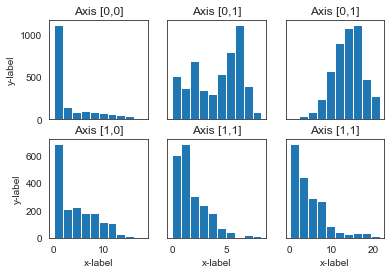

In [98]:
y = new_df.life_expectancy

xhiv = np.log(new_df['hiv'])
xalco = new_df['alcohol']
xbmi = new_df['bmi']
xgdp = np.log(new_df['gdp'])
xinf = np.cbrt(new_df['inf_death'])
xthin = new_df['thinness_till19']

fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(xhiv)
axs[0, 0].set_title('Axis [0,0]')

axs[0, 1].hist(xbmi)
axs[0, 1].set_title('Axis [0,1]')

axs[0, 2].hist(xgdp)
axs[0, 2].set_title('Axis [0,1]')

axs[1, 0].hist(xalco)
axs[1, 0].set_title('Axis [1,0]')

axs[1, 1].hist(xinf)
axs[1, 1].set_title('Axis [1,1]')

axs[1, 2].hist(xthin)
axs[1, 2].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [ ]:
# transform our independent variable to be more normally distrubuted so model will fit better 
df['alcohol'].apply(np.cbrt).hist(density=True)
df['life_expectancy'].apply(np.square).hist(density=True)

AttributeError: 'Rectangle' object has no property 'kind'

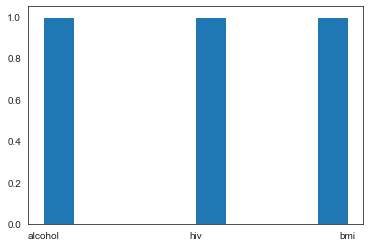

In [59]:
depended = ['life_expectancy']
features = ['alcohol', 'hiv', 'bmi', 'thinness_till19', 'hepatitisB', 'gdp']
n = 3
row_groups = [features[i:i+n] for i in range(0, len(features), n)]
for ind in row_groups:
    plot = sns.pairplot(x_vars=ind, y_vars=depended, data=df, kind="reg", height=3)

(1742, 14)

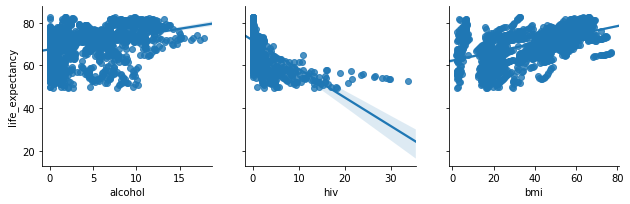

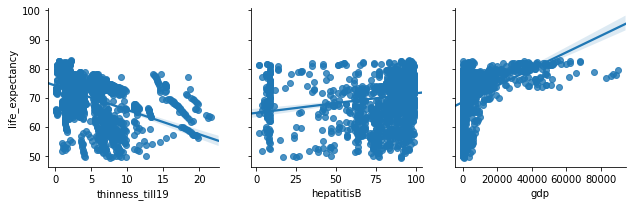

In [22]:
df = df[df.gdp < 105000] 
df = df[df.thinness_till19 < 25]
df = df[df.hiv < 35]
for ind in row_groups:
    plot = sns.pairplot(x_vars=ind, y_vars=depended, data=df, kind="reg", height=3)
    
df.shape

In [23]:
id_lr_model = ols(formula='life_expectancy~alcohol+hiv+bmi+thinness_till19+hepatitisB+gdp', data=df).fit()
id_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     471.5
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        14:46:30   Log-Likelihood:                -5139.7
No. Observations:                1742   AIC:                         1.029e+04
Df Residuals:                    1735   BIC:                         1.033e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          64.1407      0.532    120.500      0.000      63.097      65.185
alcohol             0.2922      0.032      9.249      0.000       0.230       0.354
hiv                -1.0611      0.036    -29.529      0.000      -1.132      -0.991
bmi                 0.0874      0.007     12.717      0.000       0.074       0.101
thinness_till19    -0.2191      0.034     -6.438      0.000      -0.286      -0.152
hepatitisB          0.0331      0.005      7.186      0.000       0.024       0.042
gdp                 0.0002   1.03e-05     15.092      0.000       0.000       0.000
==============================================================================
Omnibus:                       15.716   Durbin-Watson:                   0.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.320
Skew:                          -0.179   Prob(JB):                     0.000173
Kurtosis:                       3.331   Cond. No.                     6.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X = df[['hiv', 'bmi','alcohol','gdp', 'hepatitisB']].values
y = df.life_expectancy.values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)


In [ ]:
print(model.intercept_)
print(model.coef_)

In [ ]:
y_predict = model.predict(x_test)
new_df = pd.DataFrame({'actual': y_test.flatten(), 'predicted': y_predict.flatten()})
new_df
plot_df = new_df.head(20)
plot_df.plot(kind='bar', figsize=(10,8))

In [ ]:
print('mean absolete error:', metrics.mean_absolute_error(y_test, y_predict))
print('mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))